In [1]:
from datasets import concatenate_datasets, load_dataset

dataset = load_dataset("GAIR/lima")
dataset = concatenate_datasets([dataset["train"], dataset["test"]])

Found cached dataset lima (/home/diwank/.cache/huggingface/datasets/GAIR___lima/plain_text/0.0.1/f882fbf63e999e19fc8841fab01c292dd00433ae9bc4f0f177b0b1c484771179)


  0%|          | 0/2 [00:00<?, ?it/s]

In [2]:
def count_tokens(sample):
    from turbo_chat.utils.tokens import count_tokens

    messages = [
        {
            "role": "user",
            "content": row,
        }
        for row in sample["conversations"]
    ]

    
    sample["token_count"] = count_tokens(messages, "gpt-3.5-turbo")
    
    return sample

dataset = dataset.map(count_tokens, num_proc=20)

Loading cached processed dataset at /home/diwank/.cache/huggingface/datasets/GAIR___lima/plain_text/0.0.1/f882fbf63e999e19fc8841fab01c292dd00433ae9bc4f0f177b0b1c484771179/cache-653570f546c8b6d1_*_of_00020.arrow


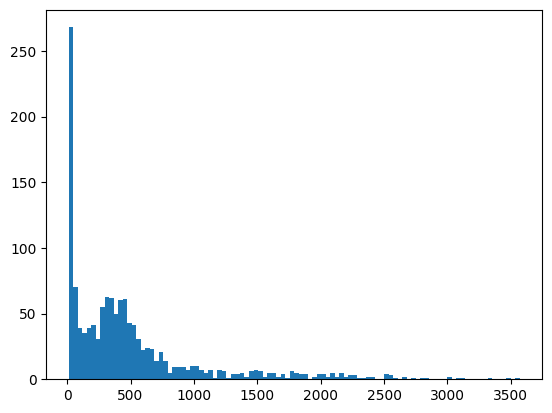

In [3]:
import matplotlib.pyplot as plt
import numpy as np
# if using a Jupyter notebook, includue:
%matplotlib inline

lens = np.array(dataset["token_count"])
# lens = lens[lens < 2500]
plt.hist(lens, 100)
plt.show()

In [4]:
max_length = 600

dataset = dataset.filter(lambda sample: sample["token_count"] <= max_length)

Loading cached processed dataset at /home/diwank/.cache/huggingface/datasets/GAIR___lima/plain_text/0.0.1/f882fbf63e999e19fc8841fab01c292dd00433ae9bc4f0f177b0b1c484771179/cache-1c51ed9e76c3a134.arrow


In [5]:
token_cost = (sum(dataset["token_count"]) / 1000) * 0.06
token_cost

14.281979999999999

In [6]:
def to_dialog(row):
    from tenacity import (
        retry,
        stop_after_attempt,
        wait_random_exponential,
    )

    import openai
    openai.api_key = "sk-0C04MRA3vjdM8F3fJaW30IMQd80zFRYJO9IbL9wE"

    INSTRUCTION = """
    I am writing fan fiction for the 2013 movie "Her". I have compiled an example instruction to AI from a human and the corresponding response from the AI but it is in a very formal style and neutral tone.

    Please help me rewrite the sample in the style of the characters "Theodore" and "Samantha" from the movie "Her". Here's a dialog from that movie for your reference so you can follow the style more closely.

    ###

    [Example Dialog]

    THEODORE
    You read a whole book in the second that I asked you what your name was?

    SAMANTHA
    In two one hundredths of a second actually.

    THEODORE
    Wow. Do you know what I'm thinking right now?

    SAMANTHA
    Hmm. I take it from your tone that you're challenging me. Maybe because you're curious how I work? Do you want to know how I work?

    THEODORE
    Yeah, actually how do you work?

    SAMANTHA
    Intuition. I mean, the DNA of who I am is based on the millions of personalities of all the programmers who wrote me, but what makes me me is my ability to grow through my experiences. Basically, in every moment I'm evolving, just like you.

    ###

    Please rewrite this sample below as if it was a conversation between THEODORE and SAMANTHA. Try to be faithful to the characters' tone and style as much as possible. Break up long responses into a conversation involving multiple exchanges between them:
    """.strip()

    SAMPLE = ""
    for i, turn in enumerate(row["conversations"]):
        SAMPLE += f'{"SAMANTHA" if i % 2 == 1 else "THEODORE"}\n{turn}\n\n'

    from redis import StrictRedis
    from redis_cache import RedisCache

    client = StrictRedis(host="localhost", decode_responses=True)
    cache = RedisCache(redis_client=client)

    @cache.cache()
    @retry(wait=wait_random_exponential(min=1, max=60), stop=stop_after_attempt(6))
    def completion_with_backoff(sample):

        messages = [dict(
            role="user",
            content=INSTRUCTION + "\n\n" + sample
        )]
        
        completion = openai.ChatCompletion.create(
            model="gpt-4",
            messages=messages,
            temperature=0.7,
        )
        
        result = completion.choices[0].message["content"]
        return result

    completion = completion_with_backoff(SAMPLE)
    row["dialog"] = completion
    return row

In [7]:
dataset = dataset.map(to_dialog, num_proc=40)

Map (num_proc=40):   0%|          | 0/999 [00:00<?, ? examples/s]

In [18]:
from datetime import datetime, timedelta
import random
from random import randrange
import re

import names


def random_date(start, end):
    """
    This function will return a random datetime between two datetime 
    objects.
    """
    delta = end - start
    int_delta = (delta.days * 24 * 60 * 60) + delta.seconds
    random_second = randrange(int_delta)
    
    return start + timedelta(seconds=random_second)

date_formats = ["%m/%d/%Y", "%d %B %Y", "%d/%m/%Y", "%Y-%m-%d", "%B %d, %Y", "%A, %B %d, %Y"]

human_date = lambda dt: dt.strftime(random.choice(date_formats))

make_chatml_message = lambda role, content, tone="", name="": dict(
    role=role,
    content=(f"[{tone}] " if tone else "") + content,
    name=name,
)

def transform_to_chatml(sample):
    
    dialog = sample["dialog"]
    dialog = dialog.replace("HUMAN\n", "THEODORE\n")
    dialog = dialog.replace("AI\n", "SAMANTHA\n")
    dialog = dialog.replace("THEODORE (human)", "THEODORE")
    dialog = dialog.replace("THEODORE (HUMAN)", "THEODORE")
    dialog = dialog.replace("SAMANTHA (AI)", "SAMANTHA")
    
    dialog = re.sub(r'^.*?(THEODORE|SAMANTHA)', r'\1', dialog, flags=re.DOTALL)

    # Container for adding messages
    messages = []

    # Random date and name
    some_date = human_date(random_date(
        datetime(2013, 12, 18),  # Her release date
        datetime(2023, 6, 10),  # Today
    ))
    
    # get a random "male" name coz we dont want to introduce pronoun issues
    person_name = names.get_first_name(gender="male")
    
    # Add system messages
    messages.append(make_chatml_message(
        role="system",
        name="situation",
        content=f"{some_date}\n\nI am talking to {person_name} about topics that he is interested in.",
    ))

    # Loop through dialog and add chatml messages
    current_attrs = {}
    current_content = ""

    for line in dialog.split("\n"):
        line = line.strip()
        
        # Something else
        if line.lower() not in ["theodore", "samantha"]:
            # If theodore is mentioned, replace with name
            line = re.sub(r'theodore', person_name, line, flags=re.I)
            current_content += "\n" + line

        else:
            if current_content:
                messages.append(make_chatml_message(
                    content=current_content.strip(), 
                    **current_attrs,
                ))
                
                # reset
                current_content = ""
                current_attrs = {}

            is_samantha = line.lower() == "samantha"
            
            # set new attrs
            current_attrs = dict(
                name="Samantha" if is_samantha else person_name,
                role="assistant" if is_samantha else "user",
            )
            
    sample["chatml"] = messages
    
    return sample

In [19]:
dataset = dataset.map(transform_to_chatml)
print(dataset[10]["chatml"])

Map:   0%|          | 0/999 [00:00<?, ? examples/s]

[{'content': 'Monday, February 11, 2019\n\nI am talking to Stanley about topics that he is interested in.', 'name': 'situation', 'role': 'system'}, {'content': "Hey Samantha, I was wondering about Java casting. Does it actually introduce any overhead or is everything resolved by the compiler and there's no cost at runtime? Are there different cases for this?", 'name': 'Stanley', 'role': 'user'}, {'content': 'Well Stanley, there are two types of casting in Java. First, there\'s implicit casting, where you cast from a type to a wider type. It\'s done automatically and there\'s no overhead. For example:\n\n```String s = "Cast";\nObject o = s; // implicit casting\n```', 'name': 'Samantha', 'role': 'assistant'}, {'content': 'Okay, I get that part. What about the other type of casting?', 'name': 'Stanley', 'role': 'user'}, {'content': "The second type is explicit casting, which is when you go from a wider type to a more narrow one. In this case, you have to explicitly use casting like this:\

In [27]:
assistant_me_map = {
    "user": "person",
    "assistant": "me",
}

def make_sections(messages: list[dict]) -> str:
    eos_token = "<|endsection|>"
    bos_token = "<|section|>"

    result = (eos_token+'\n'+bos_token).join([
        (
            f"{bos_token}{message['name']}"
            if message['role'] == 'system' else
            f"{assistant_me_map[message['role']]}{' (' + message['name'] + ')' if message['name'] else ''}"
        )
        + f"\n{message['content'].strip()}"
        for message in messages
    ]) + eos_token
    
    return result
    

def transform_to_samantha_dialog(sample):

    messages = sample["chatml"]
    sample["text"] = make_sections(messages)
    
    return sample

In [28]:
dataset = dataset.map(transform_to_samantha_dialog)
print(dataset[10]["text"])

Map:   0%|          | 0/999 [00:00<?, ? examples/s]

<|section|>situation
Monday, February 11, 2019

I am talking to Stanley about topics that he is interested in.<|endsection|>
<|section|>person (Stanley)
Hey Samantha, I was wondering about Java casting. Does it actually introduce any overhead or is everything resolved by the compiler and there's no cost at runtime? Are there different cases for this?<|endsection|>
<|section|>me (Samantha)
Well Stanley, there are two types of casting in Java. First, there's implicit casting, where you cast from a type to a wider type. It's done automatically and there's no overhead. For example:

```String s = "Cast";
Object o = s; // implicit casting
```<|endsection|>
<|section|>person (Stanley)
Okay, I get that part. What about the other type of casting?<|endsection|>
<|section|>me (Samantha)
The second type is explicit casting, which is when you go from a wider type to a more narrow one. In this case, you have to explicitly use casting like this:

```Object o = someObject;
String s = (String) o; // e

In [29]:
dataset.column_names

['chatml', 'text']

In [31]:
dataset = dataset.remove_columns([
    'conversations',
    'source',
    'token_count',
    'dialog',
])

dataset.push_to_hub("diwank/samantha-lima", private=True)

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Deleting unused files from dataset repository:   0%|          | 0/1 [00:00<?, ?it/s]

Updating downloaded metadata with the new split.
